# Fold a histogram spectra through the MagEIS isotropic response functions

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate
sns.set(font_scale=1.5)
%matplotlib inline
import sys

sys.path.append('../utils/')
import mageis_response

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/packages2/.packages2/x86_64-pc-linux-gnu-rhel7/python/3.6.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Create a true exponential spectra with E0t and J0t parameters. Then use that spectra and fold it through the MagEIS response functions to get the true counts.

In [3]:
# Spectra parameters
E0t = 100 # keV
J0t = 1E4 # 1/(cm^2 sr s keV)

# Initialize the response function
R = mageis_response.R_iso(101) # RBSP MagEIS LOW.
E = R.E*1000 # Energy channel array in keV.
n_ch = 15

# Define an exponential spectra.
def spectra(Earr, J0, E0):
    return(J0*np.exp(-Earr/E0))

# Now create the "true" counts drawn from the parent distribution. This assumes there
# is no uncertanity.
true_lambda = np.nan*np.zeros(n_ch)
for i in range(n_ch):
    true_lambda[i] = scipy.integrate.trapz(spectra(E, J0t, E0t)*R.response(i), x=E)

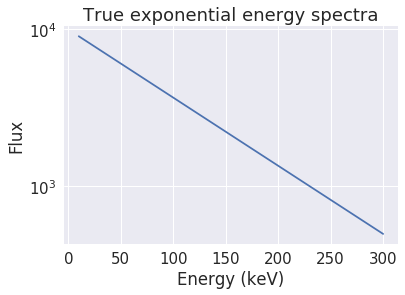

In [4]:
plt.plot(E, spectra(E, J0t, E0t)); plt.title('True exponential energy spectra')
plt.yscale('log'); plt.xlabel('Energy (keV)'); plt.ylabel('Flux');

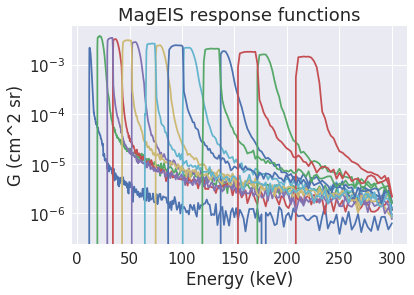

In [5]:
for i in range(n_ch):
    plt.plot(E, R.response(i), label='ch{}'.format(i));
plt.xlabel('Energy (keV)'); plt.ylabel('G (cm^2 sr)'); 
plt.title('MagEIS response functions'); plt.yscale('log');

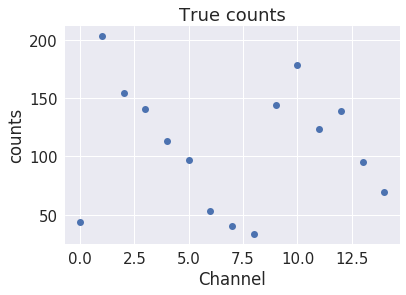

In [6]:
plt.plot(range(n_ch), true_lambda, 'o'); 
plt.ylabel('counts'); plt.xlabel('Channel'); plt.title('True counts');

Now draw observed counts from true_lambda assuming a Poisson process

In [7]:
np.random.seed(123)
c_obs = np.random.poisson(true_lambda)

### Model the spectra 

Here we are going to model the exponential spectra

In [118]:
# Make a 2-D array of reponses (nE x Nch)
response = np.ones((len(E), n_ch), dtype=object)
for i in range(response.shape[1]):
    response[:, i] = R.response(i)

Define the histogram spectra bins, and find indicies of E array that correpond to those bin edges.

In [132]:
# Define the energy channel boundaries for the spectra
nE = 10
E_bins = np.linspace(E[0], E[-1], num=nE+1)
istart = [np.where(E >= i)[0][0] for i in E_bins][:-1]
iend = [np.where(E <= i)[0][-1] for i in E_bins][1:]

#for (est, een, ist, ien) in zip(E_bins[:-1], E_bins[1:], istart, iend):
#    print(est, een, E[ist], E[ien])

In [152]:
m = pm.Model()

def lam(JJ):
    """
    This function appears to the only way to correctly work with pymc3 and 
    propagate the sampled spectra though the instrument response functions.
    My implementation of trapezium is not the fastest, but it will do.
    """
    lams = len(c_obs)*[0]
    
    for ch in range(n_ch):
        # Reset the folded spectra through reponse function.
        f = len(E)*[0]
        
        for i, ji in enumerate(JJ):
            # For each Ji, add the folded spectra from only that range.
            f[istart[i]:iend[i]] += ji*response[istart[i]:iend[i], ch]
        lams[ch] = pm.Deterministic('lam{}'.format(ch), 
                        0.5*pm.math.sum([sum(x) for x in zip(f[1:], f[:-1])]*(E[1:] - E[:-1])))
    return lams

with m:
    # Prior stocastic variables
    J = nE*[None]
    for i in range(nE):
        J[i] = pm.Uniform('J{}'.format(i), lower=1, upper=5E7)
    
    # Get a spectra from histSpec()
    #J = histSpec(Ji, E_bins)
    
    lams = lam(J)
    c_m = pm.Poisson('c_m', mu=lams, observed=c_obs, shape=len(c_obs))
    trace = pm.sample(1E4, tuning=1000, cores=3, step=pm.Metropolis)

AsTensorError: ('Cannot convert [Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0\n Elemwise{mul,no_inplace}.0] to TensorType', <class 'numpy.ndarray'>)

In [113]:
pm.traceplot(trace)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f187c609898>,
      dtype=object)